In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Standard fixed pricing with $p_1=p_2=...=p_n=1-\frac{k}{n}$:

In [51]:
seed = 1
np.random.seed(seed)

N_min, N_max = 10, 18
standard_revenues = []
max_revenue = []
n_vals, k_vals = [], []
for N in tqdm(range(N_min,N_max)):
    for k in range(1,N//2): # k < N/2
        standard_price = 1 - k/N
        tickets_remaining = k
        revenue = 0.0
        for costumer in range(N):
            if tickets_remaining > 0:
                v_i = np.random.uniform(low=0.0,high=1)
                if v_i >= standard_price:
                    revenue += standard_price
                    tickets_remaining -= 1
            else:
                break
        max_revenue.append(standard_price * k)
        standard_revenues.append(revenue)
        n_vals.append(N)
        k_vals.append(k)



100%|██████████| 8/8 [00:00<00:00, 7955.06it/s]


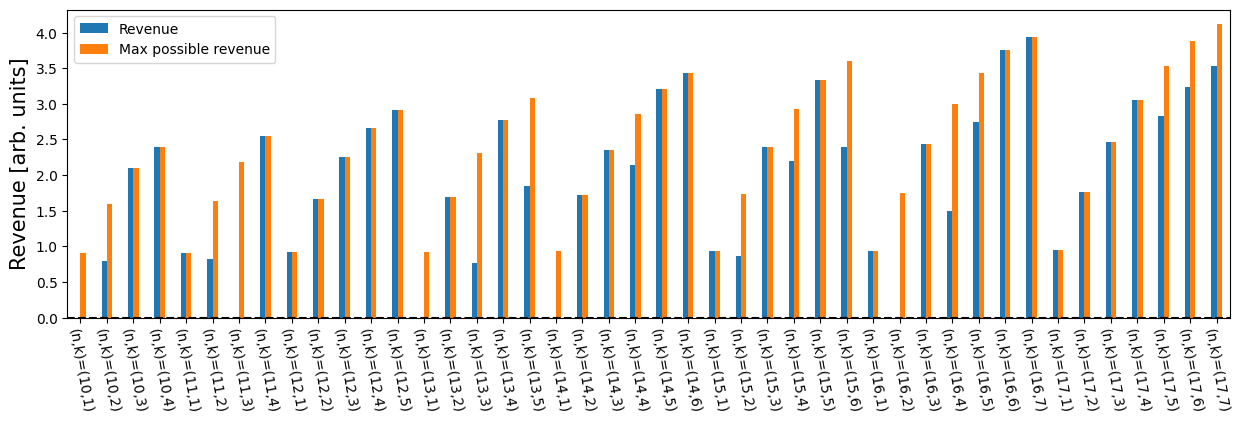

In [52]:
fig, ax = plt.subplots(1,1,figsize=(15,4))
trials = np.array([i+1 for i in range(len(standard_revenues))])

width = 0.2
ax.bar(trials - width/2,standard_revenues,width,label="Revenue")
ax.bar(trials + width/2,max_revenue,width,label="Max possible revenue")
ax.hlines(0,0.5,np.max(trials)+0.5,color='black',ls='--')

ax.set_xlim(0.5,np.max(trials)+0.5)
ax.set_ylabel("Revenue [arb. units]",size=15)

ax.set_xticks(trials)
x_tick_labels = ["(n,k)="f"({n_vals[i]},{k_vals[i]})" for i in range(len(trials))]
ax.set_xticklabels(x_tick_labels, rotation=280)

ax.legend()
plt.show()